<a href="https://colab.research.google.com/github/AanLetna7025/RespiratorySoundClassification/blob/main/ClassSound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Respiratory Sound Classification**

In [ ]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(os.listdir('/content/drive/My Drive/Colab Notebooks'))
zip_path = '/content/drive/My Drive/Colab Notebooks/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Extract into a folder named 'dataset'
path = 'dataset'
print(os.listdir(path))

['archive.zip', 'Copy of ressnd.ipynb', 'binres.ipynb', 'ressnd.ipynb', 'Copy of ClassSound.ipynb', 'ClassSound.ipynb']
['demographic_info.txt', 'respiratory_sound_database', 'Respiratory_Sound_Database']


In [ ]:
#Loading and Merging Patient Data
import pandas as pd

# Load demographic info
df_no_diagnosis = pd.read_csv('/content/dataset/demographic_info.txt', names=[
    'Patient number', 'Age', 'Sex', 'Adult BMI (kg/m2)', 'Child Weight (kg)', 'Child Height (cm)'], delimiter=' ')

# Load diagnosis info (corrected path)
diagnosis = pd.read_csv('/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',
                        names=['Patient number', 'Diagnosis'])

# Merge the datasets
merged_df = pd.merge(df_no_diagnosis, diagnosis, on='Patient number', how='inner')

# Display the first few rows
print(merged_df.head())


   Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F                NaN               19.0   
1             102   0.75   F                NaN                9.8   
2             103  70.00   F              33.00                NaN   
3             104  70.00   F              28.47                NaN   
4             105   7.00   F                NaN               32.0   

   Child Height (cm) Diagnosis  
0               99.0      URTI  
1               73.0   Healthy  
2                NaN    Asthma  
3                NaN      COPD  
4              135.0      URTI  


# **Data Visualization**

<ipython-input-5-dd230ae60d6a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=merged_df, palette='Set2')


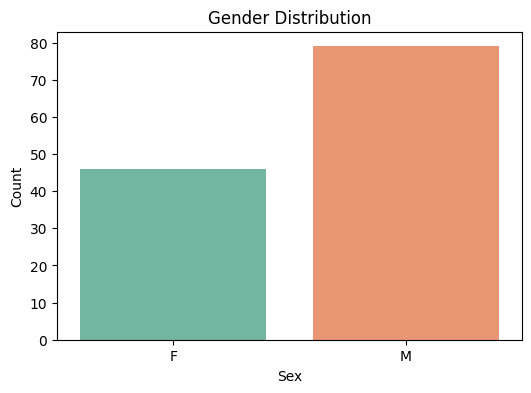

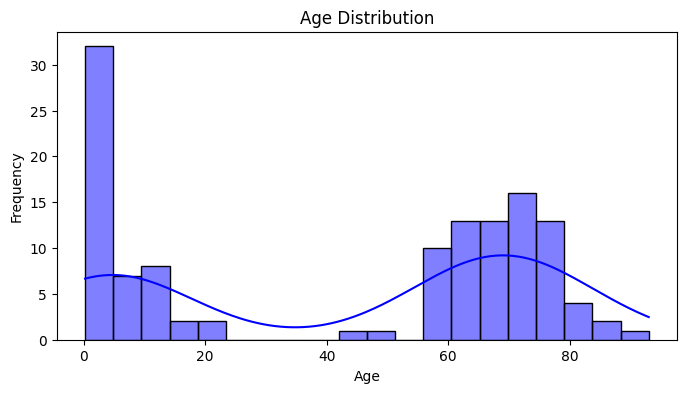

In [ ]:

# Plot gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=merged_df, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot age distribution
plt.figure(figsize=(8, 4))
sns.histplot(merged_df['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



In [ ]:
#Diagnosis Count
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()


Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [ ]:
#Extracting Audio File Names
# Corrected root path
root = '/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

# Extract filenames without the '.txt' extension
filenames = [s.split('.')[0] for s in os.listdir(root) if s.endswith('.txt')]


In [ ]:
#Extracting Annotations from Text Files
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
#Processing All Annotations
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            181             1b2             Ar               mc   
0            110             1p1             Lr               sc   
0            158             1p4             Tc               mc   
0            198             1b5             Ll               mc   
0            224             1b1             Tc               sc   

  Recording equipment  
0            LittC2SE  
0            Meditron  
0            AKGC417L  
0            AKGC417L  
0            Meditron

In [ ]:
#Counting Labels Per File
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [ ]:
#Creating a Dataframe with Labels
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    133_3p2_Ar_mc_AKGC417L
1    166_1p1_Ll_sc_Meditron
2    130_2b4_Lr_mc_AKGC417L
3    130_3p4_Pr_mc_AKGC417L
4    213_1p2_Lr_mc_AKGC417L
..                      ...
915  181_1b2_Ar_mc_LittC2SE
916  110_1p1_Lr_sc_Meditron
917  158_1p4_Tc_mc_AKGC417L
918  198_1b5_Ll_mc_AKGC417L
919  224_1b1_Tc_sc_Meditron

[920 rows x 1 columns]

In [ ]:
# Corrected audio path
audio_path = '/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment


  0%|          | 0/920 [00:00<?, ?it/s]

In [ ]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    133_3p2_Ar_mc_AKGC417L      COPD            133             Ar   
1    166_1p1_Ll_sc_Meditron      COPD            166             Ll   
2    130_2b4_Lr_mc_AKGC417L      COPD            130             Lr   
3    130_3p4_Pr_mc_AKGC417L      COPD            130             Pr   
4    213_1p2_Lr_mc_AKGC417L      COPD            213             Lr   
..                      ...       ...            ...            ...   
915  181_1b2_Ar_mc_LittC2SE      COPD            181             Ar   
916  110_1p1_Lr_sc_Meditron      COPD            110             Lr   
917  158_1p4_Tc_mc_AKGC417L      COPD            158             Tc   
918  198_1b5_Ll_mc_AKGC417L      COPD            198             Ll   
919  224_1b1_Tc_sc_Meditron   Healthy            224             Tc   

    Acquisition Mode Recording Equipment  
0                 mc            AKGC417L  
1                 sc            Meditron  
2                 mc            AKGC417L  
3                 mc            AKGC417L  
4                 mc            AKGC417L  
..               ...                 ...  
915               mc            LittC2SE  
916               sc            Meditron  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               sc            Meditron  

[920 rows x 6 columns]

In [ ]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [ ]:
file_label_df

filename Diagnosis Patient Number Chest Location  \
0    133_3p2_Ar_mc_AKGC417L      COPD            133             Ar   
1    166_1p1_Ll_sc_Meditron      COPD            166             Ll   
2    130_2b4_Lr_mc_AKGC417L      COPD            130             Lr   
3    130_3p4_Pr_mc_AKGC417L      COPD            130             Pr   
4    213_1p2_Lr_mc_AKGC417L      COPD            213             Lr   
..                      ...       ...            ...            ...   
915  181_1b2_Ar_mc_LittC2SE      COPD            181             Ar   
916  110_1p1_Lr_sc_Meditron      COPD            110             Lr   
917  158_1p4_Tc_mc_AKGC417L      COPD            158             Tc   
918  198_1b5_Ll_mc_AKGC417L      COPD            198             Ll   
919  224_1b1_Tc_sc_Meditron   Healthy            224             Tc   

    Acquisition Mode Recording Equipment 3 label diagnosis  
0                 mc            AKGC417L   Chronic Disease  
1                 sc            Meditron   Chronic Disease  
2                 mc            AKGC417L   Chronic Disease  
3                 mc            AKGC417L   Chronic Disease  
4                 mc            AKGC417L   Chronic Disease  
..               ...                 ...               ...  
915               mc            LittC2SE   Chronic Disease  
916               sc            Meditron   Chronic Disease  
917               mc            AKGC417L   Chronic Disease  
918               mc            AKGC417L   Chronic Disease  
919               sc            Meditron            normal  

[920 rows x 7 columns]

In [ ]:
file_label_df['Diagnosis'].value_counts()


Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

In [ ]:
from sklearn.utils import resample

# Print original class distribution
print("Original class distribution:\n", file_label_df['Diagnosis'].value_counts())

# Determine target sample count (matching the minority classes)
target_samples = 64

# Resample each class to have `target_samples`
file_label_df = file_label_df.groupby('Diagnosis', group_keys=False).apply(
    lambda x: resample(x, replace=True, n_samples=target_samples, random_state=42)
)

# Shuffle the balanced dataset
file_label_df = file_label_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print("\nBalanced class distribution:\n", file_label_df['Diagnosis'].value_counts())


Original class distribution:
 Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

Balanced class distribution:
 Diagnosis
Healthy           64
URTI              64
Pneumonia         64
Bronchiolitis     64
COPD              64
LRTI              64
Bronchiectasis    64
Asthma            64
Name: count, dtype: int64


<ipython-input-33-03b9d0c15b83>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  file_label_df = file_label_df.groupby('Diagnosis', group_keys=False).apply(


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [ ]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [ ]:
import IPython.display as ipd
ipd.Audio(sound_filename, rate=16000)

# **Preprocessing**

100%|██████████| 512/512 [01:12<00:00,  7.02it/s]


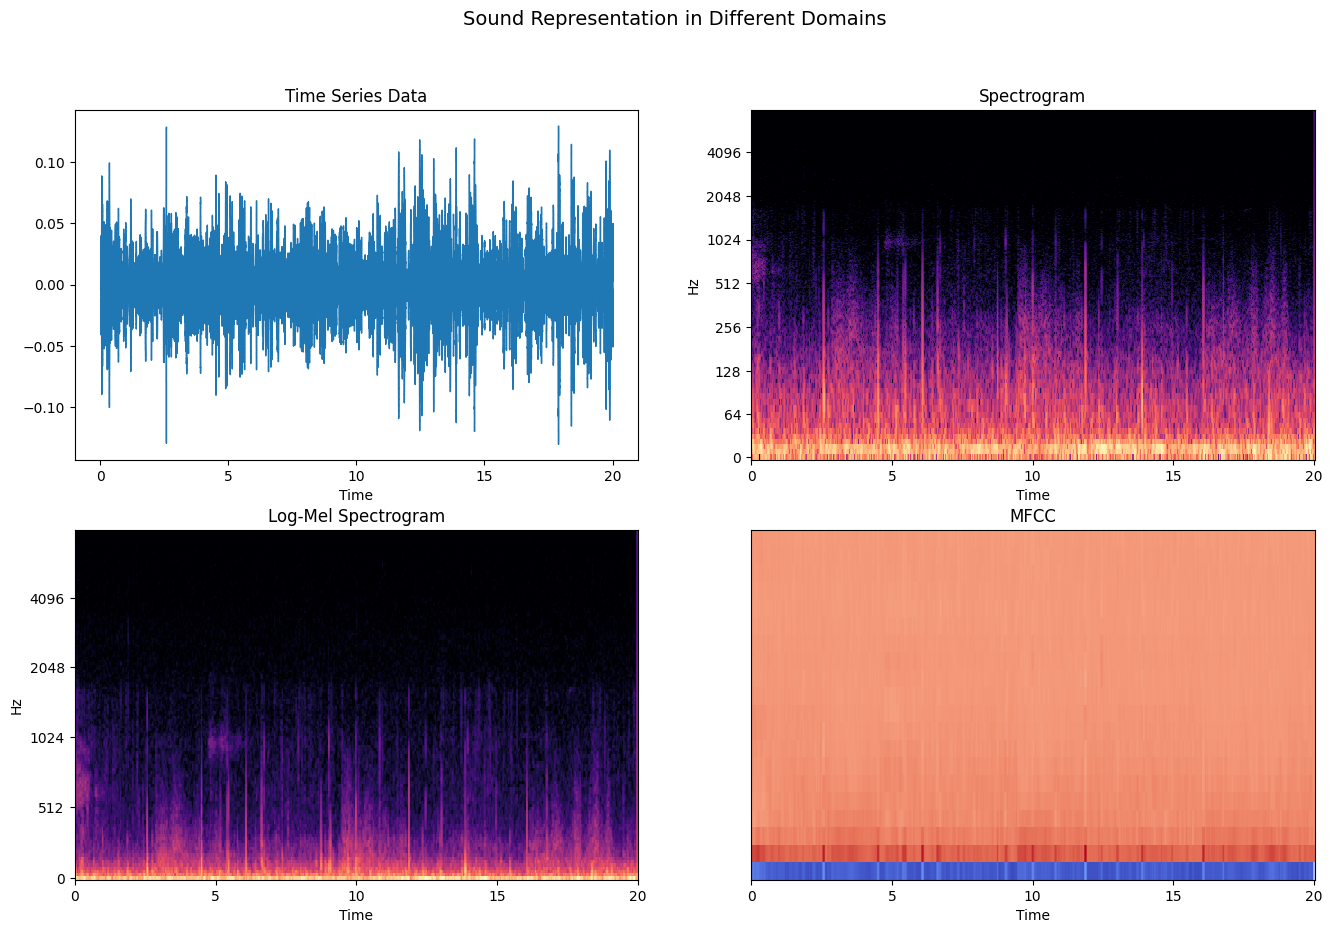

100%|██████████| 512/512 [00:52<00:00,  9.69it/s]


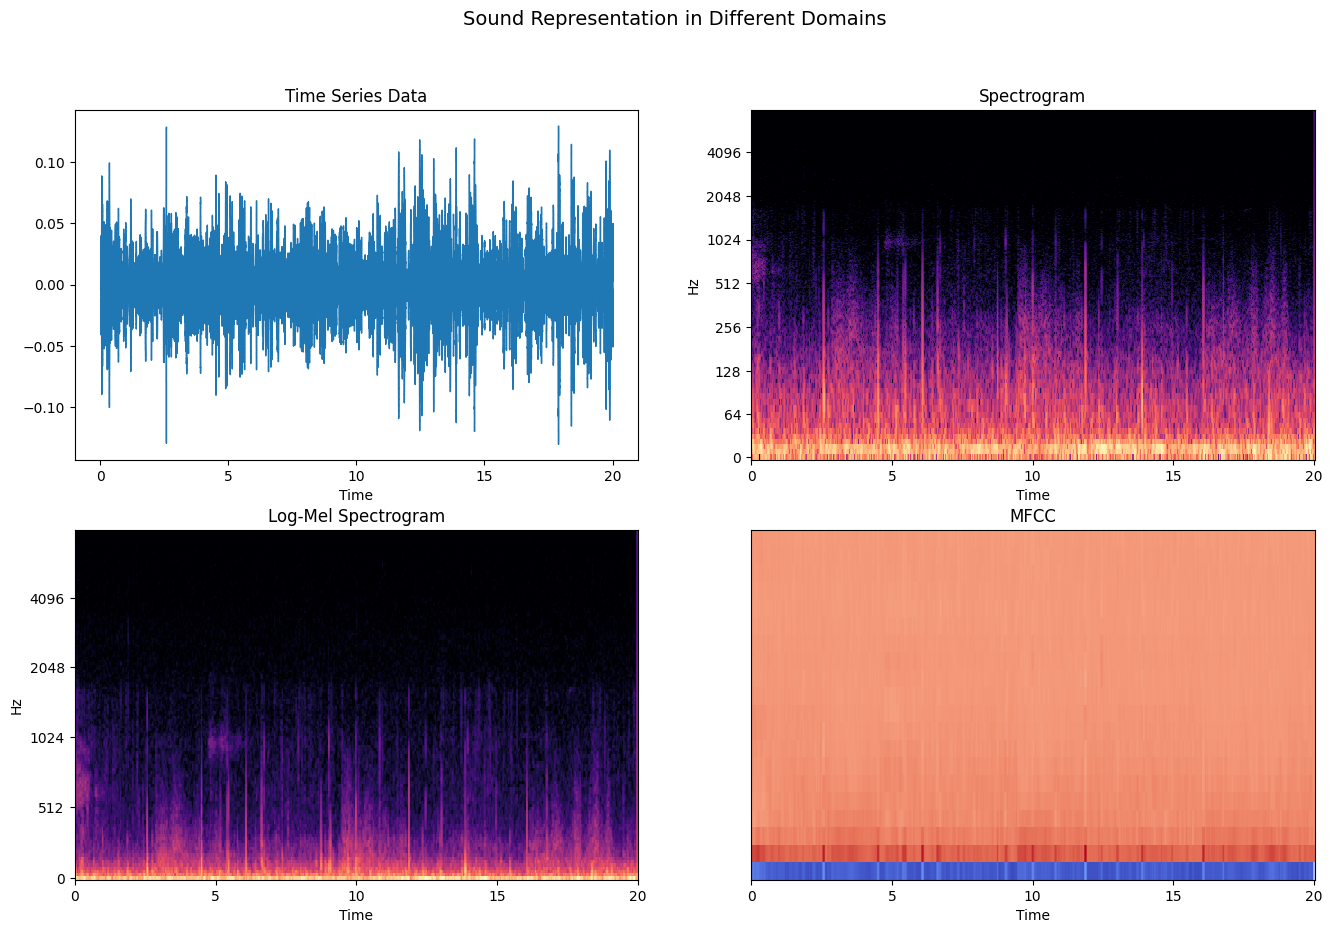

In [ ]:
import librosa
import librosa.display
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm

# Time Stretching Function (Ensure Valid Input)
def apply_time_stretch(audio, rate=1.2):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        return librosa.effects.time_stretch(y=audio.astype(np.float32), rate=rate)
    return audio  # Return unchanged if empty

# Pitch Shifting Function (Ensure Valid Input)
def apply_pitch_shift(audio, sr, n_steps=4):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        return librosa.effects.pitch_shift(audio.astype(np.float32), sr=sr, n_steps=n_steps)
    return audio

# Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Apply Bandpass Filter (Ensure Valid Input)
def apply_bandpass_filter(audio, sr, lowcut=300, highcut=3000, order=4):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        b, a = butter_bandpass(lowcut, highcut, sr, order)
        return signal.filtfilt(b, a, audio)
    return audio

# Preprocessing Function
def preprocessing(audio_file, mode='mfcc', augment=True):
    sr_new = 16000  # Resample to 16kHz
    x, sr = librosa.load(audio_file, sr=sr_new, mono=True)  # Ensure mono

    # Ensure valid audio array
    if not isinstance(x, np.ndarray) or x.size == 0:
        print(f"Warning: Empty or corrupted audio file {audio_file}")
        return None

    x = x.astype(np.float32)  # Ensure correct dtype

    # Padding or truncating audio to 5s
    max_len = 5 * sr_new
    if x.shape[0] < max_len:
        x = np.pad(x, (0, max_len - x.shape[0]))
    else:
        x = x[:max_len]

    # Apply augmentations
    if augment:
        x = apply_time_stretch(x, rate=1.1)  # Time stretch
        x = apply_pitch_shift(x, sr, n_steps=2)  # Pitch shift
        x = apply_bandpass_filter(x, sr)  # Bandpass filter

    # Extract Features
    if mode == 'mfcc':
        feature = librosa.feature.mfcc(y=x, sr=sr_new, n_mfcc=20)
    elif mode == 'log_mel':
        mel = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
        feature = librosa.power_to_db(mel, ref=np.max)

    return feature  # Returning only feature

### **Preprocess Entire Dataset**
labels = []
preprocessed_data = []

for i in tqdm(range(len(file_label_df['filename']))):
    labels.append(file_label_df['Diagnosis'][i])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    feature = preprocessing(audio_file, mode='mfcc')

    if feature is not None:
        preprocessed_data.append(feature)

# Convert to NumPy array (handle variable-length features)
preprocessed_data = np.array(preprocessed_data, dtype=object)  # Use object dtype to handle variable-sized arrays
labels = np.array(labels)

### **Fixing Feature Shape (Padding/Truncating)**
def pad_features(features, max_len=100):  # Adjust max_len as needed
    padded_features = []
    for feature in features:
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = feature[:, :max_len]
        padded_features.append(feature)
    return np.array(padded_features)

preprocessed_data = pad_features(preprocessed_data)

### **Visualizing a Sample Audio File**
sample_file = audio_path + file_label_df['filename'][100] + '.wav'
original_x, sr = librosa.load(sample_file, sr=16000)  # Load original audio

# Apply augmentations
stretched_x = apply_time_stretch(original_x, rate=1.1)
shifted_x = apply_pitch_shift(original_x, sr, n_steps=2)
filtered_x = apply_bandpass_filter(original_x, sr)

# Compute Time Axes
time_original = np.linspace(0, len(original_x) / sr, num=len(original_x))
time_stretched = np.linspace(0, len(stretched_x) / sr, num=len(stretched_x))
time_shifted = np.linspace(0, len(shifted_x) / sr, num=len(shifted_x))
time_filtered = np.linspace(0, len(filtered_x) / sr, num=len(filtered_x))

# Compute Spectrograms
X = librosa.stft(original_x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectrogram
mel = librosa.feature.melspectrogram(y=original_x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)

# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=original_x, sr=sr)

# Plot Waveform, Spectrogram, Log-Mel, MFCC
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=original_x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='Time Series Data')

librosa.display.specshow(Xdb, x_axis='time', y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='Spectrogram')

librosa.display.specshow(log_mel, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectrogram')

librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Sound Representation in Different Domains", fontsize=14)
plt.show()

import librosa
import librosa.display
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm

# Time Stretching Function (Ensure Valid Input)
def apply_time_stretch(audio, rate=1.2):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        return librosa.effects.time_stretch(y=audio.astype(np.float32), rate=rate)
    return audio  # Return unchanged if empty

# Pitch Shifting Function (Ensure Valid Input)
def apply_pitch_shift(audio, sr, n_steps=4):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        return librosa.effects.pitch_shift(audio.astype(np.float32), sr=sr, n_steps=n_steps)
    return audio

# Butterworth Bandpass Filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

# Apply Bandpass Filter (Ensure Valid Input)
def apply_bandpass_filter(audio, sr, lowcut=300, highcut=3000, order=4):
    if isinstance(audio, np.ndarray) and audio.size > 0 and audio.ndim == 1:
        b, a = butter_bandpass(lowcut, highcut, sr, order)
        return signal.filtfilt(b, a, audio)
    return audio

# Preprocessing Function
def preprocessing(audio_file, mode='mfcc', augment=True):
    sr_new = 16000  # Resample to 16kHz
    x, sr = librosa.load(audio_file, sr=sr_new, mono=True)  # Ensure mono

    # Ensure valid audio array
    if not isinstance(x, np.ndarray) or x.size == 0:
        print(f"Warning: Empty or corrupted audio file {audio_file}")
        return None

    x = x.astype(np.float32)  # Ensure correct dtype

    # Padding or truncating audio to 5s
    max_len = 5 * sr_new
    if x.shape[0] < max_len:
        x = np.pad(x, (0, max_len - x.shape[0]))
    else:
        x = x[:max_len]

    # Apply augmentations
    if augment:
        x = apply_time_stretch(x, rate=1.1)  # Time stretch
        x = apply_pitch_shift(x, sr, n_steps=2)  # Pitch shift
        x = apply_bandpass_filter(x, sr)  # Bandpass filter

    # Extract Features
    if mode == 'mfcc':
        feature = librosa.feature.mfcc(y=x, sr=sr_new, n_mfcc=20)
    elif mode == 'log_mel':
        mel = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
        feature = librosa.power_to_db(mel, ref=np.max)

    return feature  # Returning only feature

### **Preprocess Entire Dataset**
labels = []
preprocessed_data = []

for i in tqdm(range(len(file_label_df['filename']))):
    labels.append(file_label_df['Diagnosis'][i])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    feature = preprocessing(audio_file, mode='mfcc')

    if feature is not None:
        preprocessed_data.append(feature)

# Convert to NumPy array (handle variable-length features)
preprocessed_data = np.array(preprocessed_data, dtype=object)  # Use object dtype to handle variable-sized arrays
labels = np.array(labels)

### **Fixing Feature Shape (Padding/Truncating)**
def pad_features(features, max_len=100):  # Adjust max_len as needed
    padded_features = []
    for feature in features:
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = feature[:, :max_len]
        padded_features.append(feature)
    return np.array(padded_features)

preprocessed_data = pad_features(preprocessed_data)

### **Visualizing a Sample Audio File**
sample_file = audio_path + file_label_df['filename'][100] + '.wav'
original_x, sr = librosa.load(sample_file, sr=16000)  # Load original audio

# Apply augmentations
stretched_x = apply_time_stretch(original_x, rate=1.1)
shifted_x = apply_pitch_shift(original_x, sr, n_steps=2)
filtered_x = apply_bandpass_filter(original_x, sr)

# Compute Time Axes
time_original = np.linspace(0, len(original_x) / sr, num=len(original_x))
time_stretched = np.linspace(0, len(stretched_x) / sr, num=len(stretched_x))
time_shifted = np.linspace(0, len(shifted_x) / sr, num=len(shifted_x))
time_filtered = np.linspace(0, len(filtered_x) / sr, num=len(filtered_x))

# Compute Spectrograms
X = librosa.stft(original_x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectrogram
mel = librosa.feature.melspectrogram(y=original_x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)

# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=original_x, sr=sr)

# Plot Waveform, Spectrogram, Log-Mel, MFCC
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=original_x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='Time Series Data')

librosa.display.specshow(Xdb, x_axis='time', y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='Spectrogram')

librosa.display.specshow(log_mel, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectrogram')

librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Sound Representation in Different Domains", fontsize=14)
plt.show()



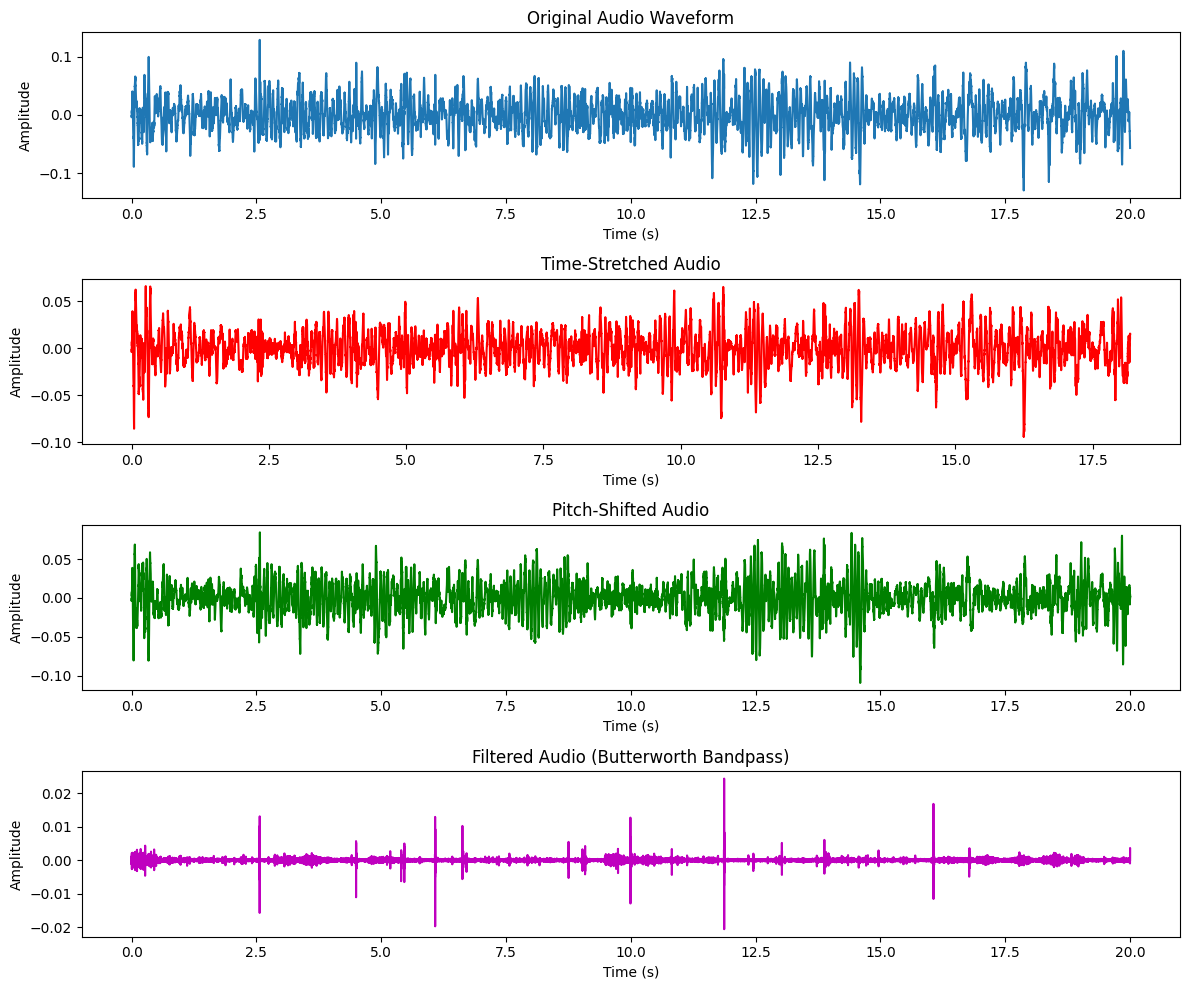

In [ ]:

# Plot Original and Augmented Audio
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

axs[0].plot(time_original, original_x)
axs[0].set_title("Original Audio Waveform")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

axs[1].plot(time_stretched, stretched_x, color='r')
axs[1].set_title("Time-Stretched Audio")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")

axs[2].plot(time_shifted, shifted_x, color='g')
axs[2].set_title("Pitch-Shifted Audio")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Amplitude")

axs[3].plot(time_filtered, filtered_x, color='m')
axs[3].set_title("Filtered Audio (Butterworth Bandpass)")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
preprocessed_data[0].shape

(20, 100)

In [ ]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 100, 1))


In [ ]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8)


In [ ]:
oh_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
print(list(encoder.classes_))

['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


In [ ]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 3584
Value: 1.0, Count: 512


# **CNN**

In [ ]:
import numpy as np
import torch
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, LSTM, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [ ]:


# Load and preprocess data
preprocessed_data = np.array(preprocessed_data, dtype=np.float32)
oh_labels = np.array(oh_labels, dtype=np.float32)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels, test_size=0.2, random_state=42)

# Ensure correct shapes
x_train = np.expand_dims(x_train, axis=-1) if x_train.ndim == 3 else x_train
x_test = np.expand_dims(x_test, axis=-1) if x_test.ndim == 3 else x_test

# Model parameters
num_labels = oh_labels.shape[1]
num_rows, num_columns, num_channels = x_train.shape[1:]
filter_size = 2

In [ ]:
# Plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

In [ ]:
# CNN Model
model_cnn = Sequential([
    Conv2D(filters=16, kernel_size=filter_size, input_shape=(num_rows, num_columns, num_channels), activation='relu'),
    MaxPooling2D(pool_size=2), Dropout(0.2),
    Conv2D(filters=32, kernel_size=filter_size, activation='relu'),
    MaxPooling2D(pool_size=2), Dropout(0.2),
    Conv2D(filters=64, kernel_size=filter_size, activation='relu'),
    MaxPooling2D(pool_size=2), Dropout(0.2),
    GlobalAveragePooling2D(), Dense(num_labels, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, batch_size=64, epochs=300, validation_split=0.1, verbose=1)
test_acc_cnn = model_cnn.evaluate(x_test, y_test, verbose=0)[1]


Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.1166 - loss: 43.5630 - val_accuracy: 0.1463 - val_loss: 13.4962
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1042 - loss: 22.8079 - val_accuracy: 0.0244 - val_loss: 13.1966
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1389 - loss: 18.3408 - val_accuracy: 0.1463 - val_loss: 9.0947
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1319 - loss: 13.7863 - val_accuracy: 0.1220 - val_loss: 9.0966
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1207 - loss: 11.8692 - val_accuracy: 0.1707 - val_loss: 4.8502
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1625 - loss: 9.9431 - val_accuracy: 0.1220 - val_loss: 7.9808
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.1934 - loss: 9.2670 - val_accuracy: 0.1463 - val_loss: 5.5180
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1839 - loss: 7.6538 - val_accuracy: 0.0976 - va

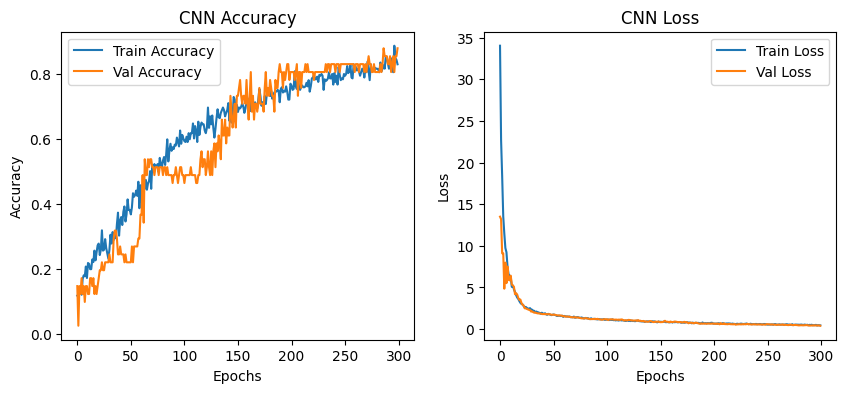

In [ ]:
plot_training_history(history_cnn, 'CNN')


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_prob = model_cnn.predict(x_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Use your actual class names from `encoder.classes_`
class_labels = list(encoder.classes_)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
                precision    recall  f1-score   support

        Asthma       0.81      1.00      0.90        13
Bronchiectasis       0.91      1.00      0.95        20
 Bronchiolitis       0.67      1.00      0.80        10
          COPD       1.00      0.83      0.91        12
       Healthy       0.70      0.58      0.64        12
          LRTI       0.86      1.00      0.92        12
     Pneumonia       0.82      0.64      0.72        14
          URTI       0.60      0.30      0.40        10

      accuracy                           0.82       103
     macro avg       0.80      0.79      0.78       103
  weighted avg       0.81      0.82      0.80       103



# **LSTM**

In [ ]:

# Convert data for LSTM/BiLSTM/GRU
x_train_seq, x_test_seq = x_train.squeeze(-1), x_test.squeeze(-1)

# Fine-tuned LSTM Model
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(num_rows, num_columns), kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    LSTM(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_lstm = model_lstm.fit(x_train_seq, y_train, batch_size=64, epochs=100, validation_split=0.1, verbose=1)
test_acc_lstm = model_lstm.evaluate(x_test_seq, y_test, verbose=0)[1]


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.1042 - loss: 2.9746 - val_accuracy: 0.1463 - val_loss: 2.5427
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2798 - loss: 2.5275 - val_accuracy: 0.2683 - val_loss: 2.5055
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2910 - loss: 2.3752 - val_accuracy: 0.3171 - val_loss: 2.5009
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.3648 - loss: 2.2410 - val_accuracy: 0.2439 - val_loss: 2.4816
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4272 - loss: 2.0358 - val_accuracy: 0.2439 - val_loss: 2.4714
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4963 - loss: 1.9182 - val_accuracy: 0.2439 - val_loss: 2.4622
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4959 - loss: 1.8372 - val_accuracy: 0.2439 - val_loss: 2.4342
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5350 - loss: 1.7711 - val_accuracy: 0.2927 - val_loss

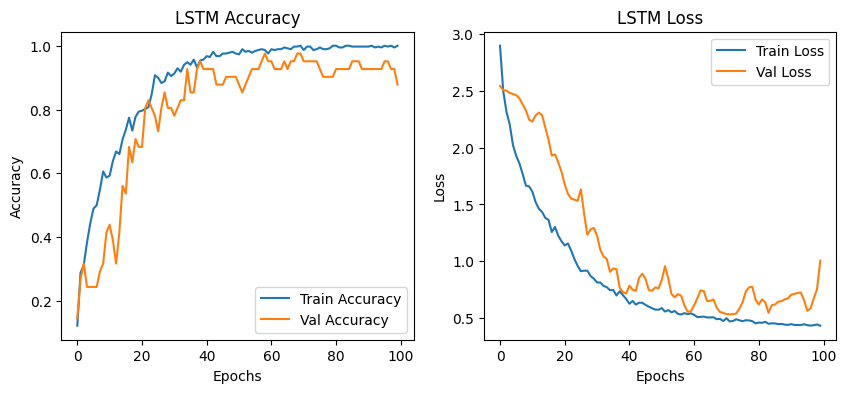

In [ ]:
plot_training_history(history_lstm, 'LSTM')


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_prob = model_lstm.predict(x_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Use your actual class names from `encoder.classes_`
class_labels = list(encoder.classes_)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00        13
Bronchiectasis       0.77      1.00      0.87        20
 Bronchiolitis       0.89      0.80      0.84        10
          COPD       1.00      0.58      0.74        12
       Healthy       1.00      1.00      1.00        12
          LRTI       1.00      1.00      1.00        12
     Pneumonia       1.00      0.79      0.88        14
          URTI       0.77      1.00      0.87        10

      accuracy                           0.90       103
     macro avg       0.93      0.90      0.90       103
  weighted avg       0.92      0.90      0.90       103



# **BiLSTM**

In [ ]:

# BiLSTM Model
model_bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(num_rows, num_columns))),
    BatchNormalization(), Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(), Dropout(0.3),
    Bidirectional(LSTM(32)),
    BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

model_bilstm.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history_bilstm = model_bilstm.fit(x_train_seq, y_train, batch_size=64, epochs=100, validation_split=0.1, verbose=1)
test_acc_bilstm = model_bilstm.evaluate(x_test_seq, y_test, verbose=0)[1]



Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 348ms/step - accuracy: 0.1690 - loss: 2.4435 - val_accuracy: 0.2195 - val_loss: 2.0411
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.2311 - loss: 2.1215 - val_accuracy: 0.1951 - val_loss: 1.9909
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.3335 - loss: 1.9341 - val_accuracy: 0.2195 - val_loss: 1.9604
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4282 - loss: 1.6398 - val_accuracy: 0.2195 - val_loss: 1.9412
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4400 - loss: 1.4537 - val_accuracy: 0.2439 - val_loss: 1.9068
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5192 - loss: 1.4041 - val_accuracy: 0.2439 - val_loss: 1.8754
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5341 - loss: 1.3227 - val_accuracy: 0.3171 - val_loss: 1.8293
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5396 - loss: 1.2940 - val_accuracy: 0.4390 - 

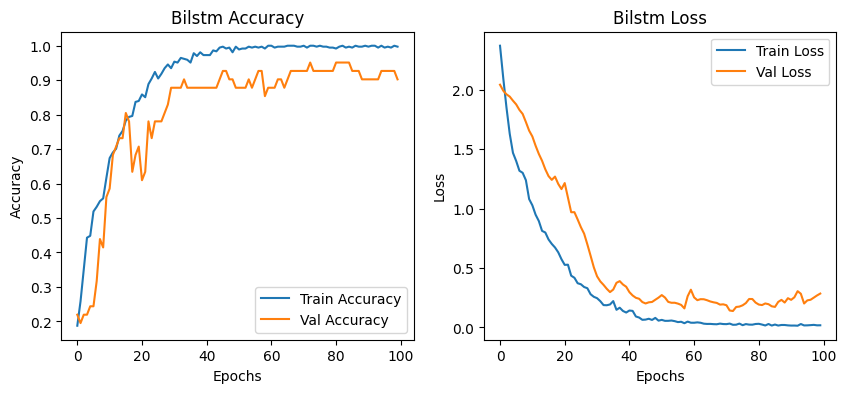

In [ ]:
plot_training_history(history_bilstm, 'Bilstm')


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_prob = model_bilstm.predict(x_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Use your actual class names from `encoder.classes_`
class_labels = list(encoder.classes_)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00        13
Bronchiectasis       1.00      1.00      1.00        20
 Bronchiolitis       0.73      0.80      0.76        10
          COPD       0.91      0.83      0.87        12
       Healthy       0.73      0.92      0.81        12
          LRTI       1.00      1.00      1.00        12
     Pneumonia       1.00      0.79      0.88        14
          URTI       1.00      1.00      1.00        10

      accuracy                           0.92       103
     macro avg       0.92      0.92      0.92       103
  weighted avg       0.93      0.92      0.92       103



# **GRU**

In [ ]:

# GRU Model
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(num_rows, num_columns), kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    GRU(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    GRU(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), Dropout(0.3),
    Dense(num_labels, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

# Train models
history_gru = model_gru.fit(x_train_seq, y_train, batch_size=64, epochs=100, validation_split=0.1, verbose=1)

# Evaluate models
test_acc_gru = model_gru.evaluate(x_test_seq, y_test, verbose=0)[1]

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.1666 - loss: 2.7244 - val_accuracy: 0.3902 - val_loss: 2.3848
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.2907 - loss: 2.4184 - val_accuracy: 0.3659 - val_loss: 2.3008
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3706 - loss: 2.2121 - val_accuracy: 0.4390 - val_loss: 2.2318
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.3870 - loss: 2.1542 - val_accuracy: 0.4146 - val_loss: 2.1665
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3875 - loss: 2.0562 - val_accuracy: 0.4878 - val_loss: 2.1081
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4183 - loss: 1.9831 - val_accuracy: 0.4878 - val_loss: 2.0588
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4515 - loss: 1.8417 - val_accuracy: 0.4878 - val_loss: 2.0074
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4607 - loss: 1.8702 - val_accuracy: 0.5366 - val_loss

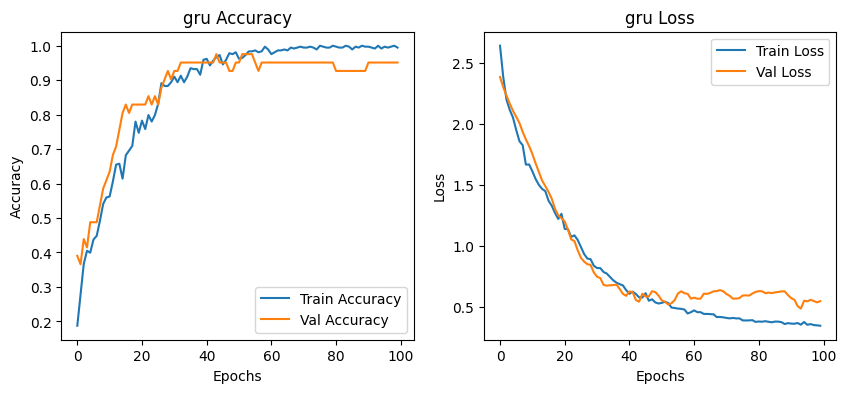

In [ ]:
plot_training_history(history_gru, 'gru')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_prob = model_gru.predict(x_test)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Use your actual class names from `encoder.classes_`
class_labels = list(encoder.classes_)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00        13
Bronchiectasis       0.95      1.00      0.98        20
 Bronchiolitis       0.89      0.80      0.84        10
          COPD       1.00      0.83      0.91        12
       Healthy       0.79      0.92      0.85        12
          LRTI       1.00      1.00      1.00        12
     Pneumonia       0.87      0.93      0.90        14
          URTI       1.00      0.90      0.95        10

      accuracy                           0.93       103
     macro avg       0.94      0.92      0.93       103
  weighted avg       0.94      0.93      0.93       103



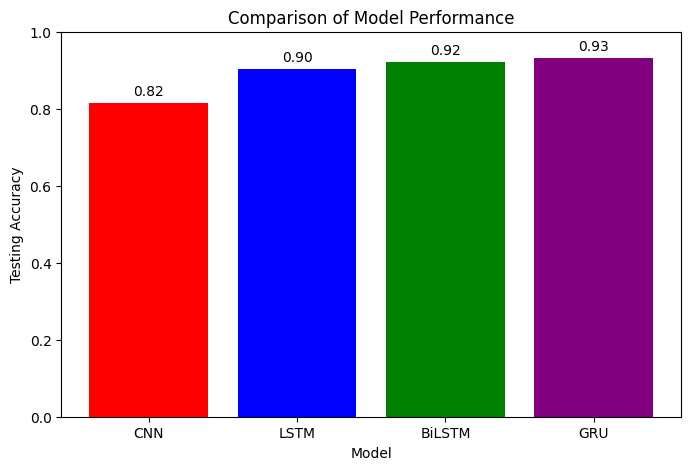

In [ ]:
# Compare model performances
def plot_model_comparison():
    models = ['CNN', 'LSTM', 'BiLSTM', 'GRU']
    accs = [test_acc_cnn, test_acc_lstm, test_acc_bilstm, test_acc_gru]

    plt.figure(figsize=(8, 5))
    plt.bar(models, accs, color=['red', 'blue', 'green', 'purple'])
    plt.xlabel('Model')
    plt.ylabel('Testing Accuracy')
    plt.title('Comparison of Model Performance')
    plt.ylim(0, 1)
    for i, v in enumerate(accs):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.show()

plot_model_comparison()



# **Multi-Feature BiLSTM with attention**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Attention, Concatenate, Reshape
from tensorflow.keras.models import Model

# Define Input Layers for Different Features
mfcc_input = Input(shape=(num_rows, num_columns, num_channels), name="mfcc_input")
chroma_input = Input(shape=(num_rows, num_columns, num_channels), name="chroma_input")
mel_spec_input = Input(shape=(num_rows, num_columns, num_channels), name="mel_spec_input")

# Reshape to (timesteps, features) for LSTM
mfcc_reshaped = Reshape((num_rows, num_columns * num_channels))(mfcc_input)
chroma_reshaped = Reshape((num_rows, num_columns * num_channels))(chroma_input)
mel_spec_reshaped = Reshape((num_rows, num_columns * num_channels))(mel_spec_input)

# Define LSTM branches
mfcc_lstm = Bidirectional(LSTM(128, return_sequences=True))(mfcc_reshaped)
mfcc_lstm = Dropout(0.3)(mfcc_lstm)

chroma_lstm = Bidirectional(LSTM(128, return_sequences=True))(chroma_reshaped)
chroma_lstm = Dropout(0.3)(chroma_lstm)

mel_spec_lstm = Bidirectional(LSTM(128, return_sequences=True))(mel_spec_reshaped)
mel_spec_lstm = Dropout(0.3)(mel_spec_lstm)

# Attention Mechanism
attention_layer = Attention()([mfcc_lstm, chroma_lstm, mel_spec_lstm])
merged = Concatenate()([mfcc_lstm, chroma_lstm, mel_spec_lstm, attention_layer])

# Fully Connected Layers
flattened = Reshape((-1,))(merged)
dense1 = Dense(256, activation='relu')(flattened)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
dense2 = Dropout(0.3)(dense2)
output_layer = Dense(num_labels, activation='softmax', name="output_layer")(dense2)

# Compile Model
model = Model(inputs=[mfcc_input, chroma_input, mel_spec_input], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Print Model Summary
model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input (InputLayer)   │ (None, 20, 100, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chroma_input (InputLayer) │ (None, 20, 100, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mel_spec_input            │ (None, 20, 100, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_16 (Reshape)      │ (None, 20, 100)        │              0 │ mfcc_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_17 (Reshape)      │ (None, 20, 100)        │              0 │ chroma_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_18 (Reshape)      │ (None, 20, 100)        │              0 │ mel_spec_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_18          │ (None, 20, 256)        │        234,496 │ reshape_16[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_19          │ (None, 20, 256)        │        234,496 │ reshape_17[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_20          │ (None, 20, 256)        │        234,496 │ reshape_18[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_53 (Dropout)      │ (None, 20, 256)        │              0 │ bidirectional_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_54 (Dropout)      │ (None, 20, 256)        │              0 │ bidirectional_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_55 (Dropout)      │ (None, 20, 256)        │              0 │ bidirectional_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_4 (Attention)   │ (None, 20, 256)        │              0 │ dropout_53[0][0],      │
│                           │                        │                │ dropout_54[0][0],      │
│                           │                        │                │ dropout_55[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 20, 1024)       │              0 │ dropout_53[0][0],      │
│ (Concatenate)             │                        │                │ dropout_54[0][0],      │
│                           │                        │                │ dropout_55[0][0],      │
│                           │                        │                │ attention_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_19 (Reshape)      │ (None, 20480)          │              0 │ concatenate_7[0][0]    │
├──────────────────────

 Total params: 5,980,552 (22.81 MB)

 Trainable params: 5,980,552 (22.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Function to extract multiple features
def extract_features(audio_file, sr=16000):
    x, sr = librosa.load(audio_file, sr=sr, mono=True)

    # Padding/truncation to 5 seconds
    max_len = 5 * sr
    if len(x) < max_len:
        x = np.pad(x, (0, max_len - len(x)), mode='constant')
    else:
        x = x[:max_len]

    # Feature extraction
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=x, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=x, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sr)

    return mfcc, chroma, mel_spec, spectral_contrast

# Load dataset
X_mfcc, X_chroma, X_mel_spec, X_spec_contrast, y = [], [], [], [], []

for i in range(len(file_label_df['filename'])):
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    mfcc, chroma, mel_spec, spec_contrast = extract_features(audio_file)

    X_mfcc.append(mfcc)
    X_chroma.append(chroma)
    X_mel_spec.append(mel_spec)
    X_spec_contrast.append(spec_contrast)
    y.append(file_label_df['Diagnosis'][i])

# Convert to numpy arrays
X_mfcc = np.array(X_mfcc)
X_chroma = np.array(X_chroma)
X_mel_spec = np.array(X_mel_spec)
X_spec_contrast = np.array(X_spec_contrast)
y = np.array(y)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

# Train-test split
X_mfcc_train, X_mfcc_test, X_chroma_train, X_chroma_test, X_mel_train, X_mel_test, X_spec_train, X_spec_test, y_train, y_test = train_test_split(
    X_mfcc, X_chroma, X_mel_spec, X_spec_contrast, y_one_hot, test_size=0.2, random_state=42
)

# Reshape inputs
X_mfcc_train = X_mfcc_train[..., np.newaxis]
X_mfcc_test = X_mfcc_test[..., np.newaxis]
X_chroma_train = X_chroma_train[..., np.newaxis]
X_chroma_test = X_chroma_test[..., np.newaxis]
X_mel_train = X_mel_train[..., np.newaxis]
X_mel_test = X_mel_test[..., np.newaxis]
X_spec_train = X_spec_train[..., np.newaxis]
X_spec_test = X_spec_test[..., np.newaxis]

# Define Multi-Input Model
input_mfcc = tf.keras.layers.Input(shape=X_mfcc_train.shape[1:])
input_chroma = tf.keras.layers.Input(shape=X_chroma_train.shape[1:])
input_mel = tf.keras.layers.Input(shape=X_mel_train.shape[1:])
input_spec = tf.keras.layers.Input(shape=X_spec_train.shape[1:])

def feature_branch(input_layer):
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    return x

mfcc_branch = feature_branch(input_mfcc)
chroma_branch = feature_branch(input_chroma)
mel_branch = feature_branch(input_mel)
spec_branch = feature_branch(input_spec)

merged = tf.keras.layers.concatenate([mfcc_branch, chroma_branch, mel_branch, spec_branch])
dense1 = tf.keras.layers.Dense(128, activation='relu')(merged)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(y_one_hot.shape[1], activation='softmax')(dropout1)

model = tf.keras.Model(inputs=[input_mfcc, input_chroma, input_mel, input_spec], outputs=output)

# Compile and Train Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit([X_mfcc_train, X_chroma_train, X_mel_train, X_spec_train], y_train,
                    validation_data=([X_mfcc_test, X_chroma_test, X_mel_test, X_spec_test], y_test),
                    epochs=50, batch_size=32)

# Evaluate model
test_loss, test_acc = model.evaluate([X_mfcc_test, X_chroma_test, X_mel_test, X_spec_test], y_test)
print("Test Accuracy:", test_acc)


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 933ms/step - accuracy: 0.2174 - loss: 82.9161 - val_accuracy: 0.5243 - val_loss: 2.3570
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 934ms/step - accuracy: 0.4637 - loss: 4.0174 - val_accuracy: 0.5534 - val_loss: 1.0025
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 921ms/step - accuracy: 0.6388 - loss: 1.0630 - val_accuracy: 0.8350 - val_loss: 0.9053
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 907ms/step - accuracy: 0.7234 - loss: 1.0251 - val_accuracy: 0.8641 - val_loss: 0.5446
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 924ms/step - accuracy: 0.7421 - loss: 0.7599 - val_accuracy: 0.8738 - val_loss: 0.4800
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 924ms/step - accuracy: 0.8460 - loss: 0.4729 - val_accuracy: 0.8738 - val_loss: 0.3914
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 804ms/step - accuracy: 0.8425 - loss: 0.4328 - val_accuracy: 0.9126 - val_loss: 0.3542
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 924ms/step - accuracy: 0.8632 - loss: 0.3862 - val_acc

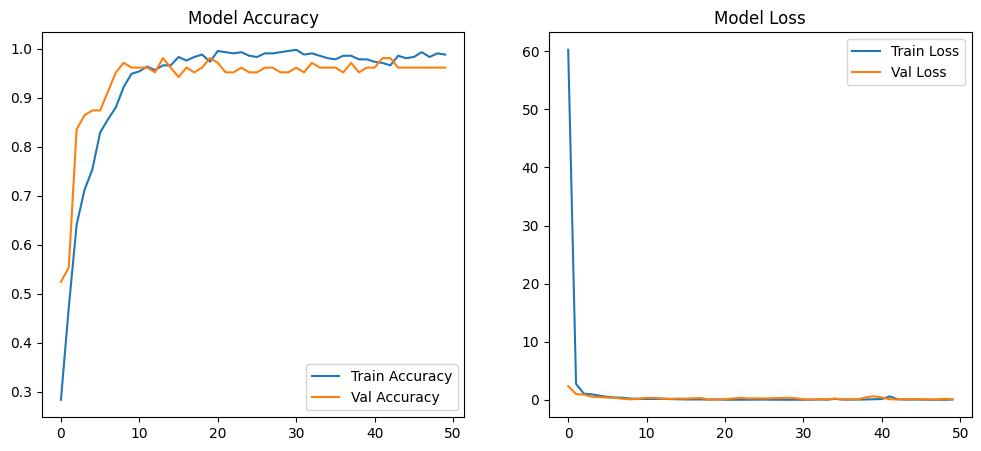

In [ ]:
# Plot Accuracy & Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(history.history['accuracy'], label="Train Accuracy")
axs[0].plot(history.history['val_accuracy'], label="Val Accuracy")
axs[0].set_title("Model Accuracy"); axs[0].legend()

axs[1].plot(history.history['loss'], label="Train Loss")
axs[1].plot(history.history['val_loss'], label="Val Loss")
axs[1].set_title("Model Loss"); axs[1].legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_prob = model.predict([X_mfcc_test, X_chroma_test, X_mel_test, X_spec_test])

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Use actual class names
class_labels = list(encoder.classes_)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)

# Path to your saved model
model_path = "/content/model/best_model.h5"

# Make the directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model
model.save(model_path)
print(f"✅ Model saved successfully to {model_path}!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00        13
Bronchiectasis       1.00      1.00      1.00        20
 Bronchiolitis       1.00      1.00      1.00        10
          COPD       0.86      1.00      0.92        12
       Healthy       0.92      0.92      0.92        12
          LRTI       1.00      1.00      1.00        12
     Pneumonia       0.92      0.86      0.89        14
          URTI       1.00      0.90      0.95        10

      accuracy                           0.96       103
     macro avg       0.96      0.96      0.96       103
  weighted avg       0.96      0.96      0.96       103

✅ Model saved successfully to /content/model/best_model.h5!


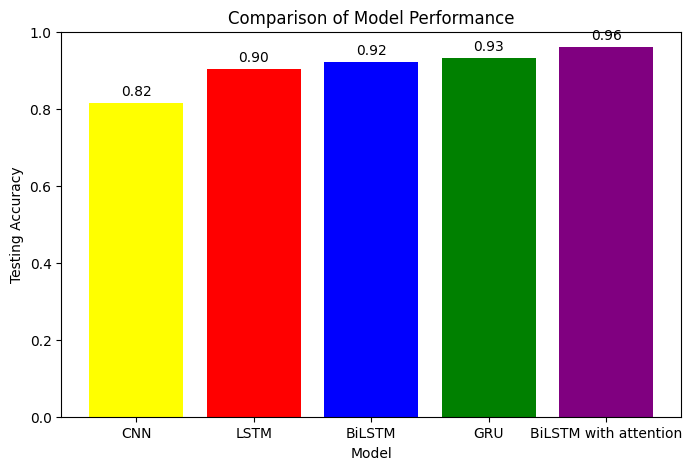

In [ ]:
# Compare model performances
def plot_model_comparison():
    models = ['CNN', 'LSTM', 'BiLSTM', 'GRU','BiLSTM with attention']
    accs = [test_acc_cnn, test_acc_lstm, test_acc_bilstm, test_acc_gru,test_acc]

    plt.figure(figsize=(8, 5))
    plt.bar(models, accs, color=['yellow','red', 'blue', 'green', 'purple'])
    plt.xlabel('Model')
    plt.ylabel('Testing Accuracy')
    plt.title('Comparison of Model Performance')
    plt.ylim(0, 1)
    for i, v in enumerate(accs):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.show()

plot_model_comparison()



In [ ]:
print(type(model))


<class 'keras.src.models.functional.Functional'>


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import librosa
import os
import pandas as pd

# Load the trained model
model_path = "/content/model/best_model.h5"
model = load_model(model_path)
print("✅ Model loaded successfully!")

# Print expected model input shape
print("📏 Expected model input shape:", model.input_shape)

# Normalize function
def normalize(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-8)

# Feature extraction function
def extract_features(audio_path, sr=16000, n_mfcc=20, n_chroma=12, n_mels=128, n_contrast=6, target_size=157):
    y, sr = librosa.load(audio_path, sr=sr)
    if len(y) == 0 or np.max(np.abs(y)) < 1e-5:
        raise ValueError("Audio file is empty or silent.")

    # Compute features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=n_contrast, fmin=100.0)

    # Adjust feature shape
    def fix_feature_shape(feature):
        return np.pad(feature, ((0, 0), (0, max(0, target_size - feature.shape[1]))), mode='constant')[:, :target_size]

    mfcc, chroma, mel_spec, spectral_contrast = map(fix_feature_shape, [mfcc, chroma, mel_spec, spectral_contrast])

    # Print extracted feature shapes
    print(f"🔍 Shapes → MFCC: {mfcc.shape}, Chroma: {chroma.shape}, Mel: {mel_spec.shape}, Contrast: {spectral_contrast.shape}")

    # Normalize and reshape
    return (
        normalize(mfcc)[np.newaxis, :, :, np.newaxis],
        normalize(chroma)[np.newaxis, :, :, np.newaxis],
        normalize(mel_spec)[np.newaxis, :, :, np.newaxis],
        normalize(spectral_contrast)[np.newaxis, :, :, np.newaxis]
    )

# Class label mapping
label_mapping = {
    0: 'URTI', 1: 'Healthy', 2: 'Asthma', 3: 'COPD',
    4: 'LRTI', 5: 'Bronchiectasis', 6: 'Pneumonia', 7: 'Bronchiolitis'
}

# Directory containing audio files
audio_dir = "/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files"

# Process audio files and make predictions
results = []
audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")][:50]

for filename in audio_files:
    audio_path = os.path.join(audio_dir, filename)
    try:
        features = extract_features(audio_path)
        print(f" Input Shape for {filename}: {[f.shape for f in features]}")  # Print final shape before prediction

        predictions = model.predict(features)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_label = label_mapping.get(predicted_class, "Unknown")
        results.append({"Filename": filename, "Predicted Disease": predicted_label})
        print(f"{filename} → {predicted_label}")
    except Exception as e:
        print(f" Error processing {filename}: {e}")

# Save predictions to CSV
csv_path = "/content/pred/predictions_50.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)
pd.DataFrame(results).to_csv(csv_path, index=False)
print(f"✅ Predictions saved to: {csv_path}")


✅ Model loaded successfully!
📏 Expected model input shape: [(None, 20, 157, 1), (None, 12, 157, 1), (None, 128, 157, 1), (None, 7, 157, 1)]
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 203_1p2_Pr_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
203_1p2_Pr_mc_AKGC417L.wav → Bronchiolitis
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 151_2p3_Tc_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
151_2p3_Tc_mc_AKGC417L.wav → Healthy
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 133_2p4_Al_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
133_2p4_Al_mc_AKGC417L.wav → Bronchiolitis
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 207_2b2_Ar_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
207_2b2_Ar_mc_AKGC417L.wav → Bronchiolitis
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 133_3p4_Tc_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
133_3p4_Tc_mc_AKGC417L.wav → Bronchiolitis
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 Input Shape for 178_2b2_Tc_mc_AKGC417L.wav: [(1, 20, 157, 1), (1, 12, 157, 1), (1, 128, 157, 1), (1, 7, 157, 1)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
178_2b2_Tc_mc_AKGC417L.wav → Bronchiolitis
🔍 Shapes → MFCC: (20, 157), Chroma: (12, 157), Mel: (128, 157), Contrast: (7, 157)
 I